In [175]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz

from IPython.display import Image

%matplotlib inline

In [176]:
# !pip install graphviz

# Load Data

In [177]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [178]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

### Question 1

In [179]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    
    n = label_array.shape[0]
    non_zeros = np.count_nonzero(label_array)
    zeros = n - non_zeros
    
    if zeros!=0 and non_zeros!=0:
        entropy = -(zeros/n)*np.log2(zeros/n)-(non_zeros/n)*np.log2(non_zeros/n)
    else:
        entropy = 0
    
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    n = label_array.shape[0]
    non_zeros = np.count_nonzero(label_array)
    zeros = n - non_zeros
    
    gini = np.sum([(zeros/n)*(1-zeros/n),(non_zeros/n)*(1-non_zeros/n)])
    
    return gini

### Question 2

In [180]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = False

    def fit(self, X, y):
        """
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want to split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        """
        n = X.shape[0]
        if self.depth >= self.max_depth or n <= self.min_sample:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self

        else:
            self.split_id, self.split_value = self.find_best_feature_split(X,y)

            #Initiate two subtrees: self.left and self.right
            split_loss_function_node = self.split_loss_function
            leaf_value_estimator_node = self.leaf_value_estimator
            depth_node = self.depth + 1
            min_sample_node = self.min_sample
            max_depth_node = self.max_depth
                
            self.left = Decision_Tree(split_loss_function_node, leaf_value_estimator_node, depth_node, min_sample_node, max_depth_node)
            self.right = Decision_Tree(split_loss_function_node, leaf_value_estimator_node, depth_node, min_sample_node, max_depth_node)
                
            x_node_left = []
            x_node_right = []
            y_node_left = []
            y_node_right = []
            for i in range(n):
                if X[i,self.split_id] < self.split_value:
                    x_node_left.append(X[i,:].tolist())
                    y_node_left.append(y[i,:].tolist())
                else:
                    x_node_right.append(X[i,:].tolist())
                    y_node_right.append(y[i,:].tolist())
                        
            x_node_left = np.asarray(x_node_left)
            x_node_right = np.asarray(x_node_right)
            y_node_left = np.asarray(y_node_left)
            y_node_right = np.asarray(y_node_right)
            
            #fit on the newly splitted samples
            self.left.fit(x_node_left, y_node_left)
            self.right.fit(x_node_right, y_node_right)
            

    def find_best_split(self, x_node, y_node, feature_id):
        """
        For feature_id, returns the optimal splitting point 
        for data X_node, y_node.
        Parameters:
            x_node: shape = (n_node, num_features)
            y_node: shape = (n_node, 1)
            feature_id: index of the feature that is about to be split on
        Returns:
            split_value: the split value that has the lowest loss
            best_loss: lowest loss generated by the split
        """
        #concat featured_x_node and y_node, sort by column specified by feature_id
        featured_x_node = x_node[:,feature_id].reshape(-1,1)
        concate_x_y = np.concatenate((featured_x_node, y_node), axis=1)
        sorted_x_y = concate_x_y[concate_x_y[:, 0].argsort()]
        
        n_node = y_node.shape[0]
        
        #Initialize split value & weighted average loss
        split_value = (sorted_x_y[0,0]+sorted_x_y[1,0].reshape(-1,1))/2#the average value of first and second ordered samples
        best_loss = (1*0 + (n_node-1)*self.split_loss_function(sorted_x_y[1:-1,1].reshape(-1,1)))/n_node
        
        #Iterate through all the possible split values
        for i in range(1,n_node-1):
            temp_split_value = (sorted_x_y[i,0]+sorted_x_y[i+1,0])/2
            temp_loss = ((i+1)*self.split_loss_function(sorted_x_y[0:i+1,1].reshape(-1,1)) \
                         + (n_node-i-1)*self.split_loss_function(sorted_x_y[i+2:-1,1].reshape(-1,1)))/n_node
            if temp_loss < best_loss:
                split_value = temp_split_value
                best_loss = temp_loss
    
        return split_value, best_loss

    def find_best_feature_split(self, x_node, y_node):
        """
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        Parameters:
            x_node: shape = (n_node, num_features)
            y_node: shape = (n_node, 1)
        Returns:
            split_id: id of the optimal feature to split
            split_value: corresponding split value
        """
        #Initialize the optimal splitting id and splitting value
        split_id = 0
        split_value, best_loss = self.find_best_split(x_node, y_node, split_id)
        
        #Iterate through all the possible features to be split on
        num_features = x_node.shape[1]
        for i in range(num_features-1):
            temp_split_value, temp_best_loss = self.find_best_split(x_node, y_node, i+1)
            if temp_best_loss <= best_loss:
                split_id = i+1
                split_value = temp_split_value
                
        return split_id, split_value
            
    def predict_instance(self, instance):
        """
        Predict label by decision tree
        Parameters:
            instance: a numpy array with new data, shape (1, m)
        Returns:
            whatever is returned by leaf_value_estimator for leaf containing instance
        """
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [181]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [182]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

### Question 3

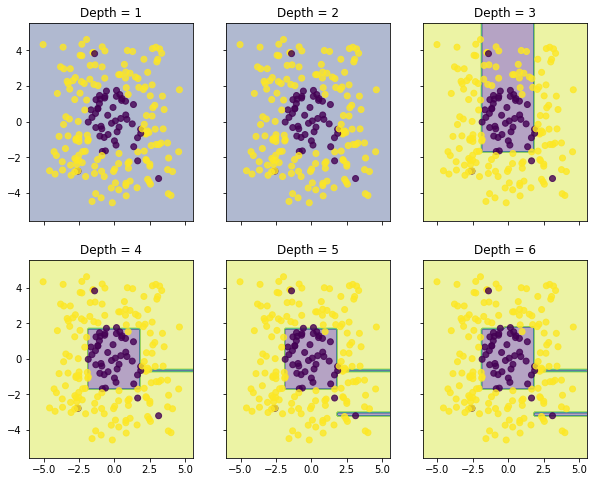

In [183]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [184]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

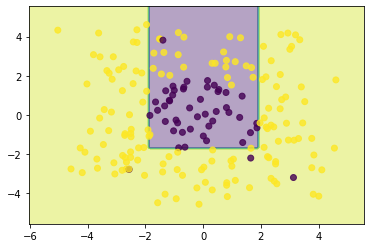

In [185]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

In [186]:
#Visualize decision tree
# !dot -Tpng tree_classifier.dot -o tree_classifier.png
# Image(filename='tree_classifier.png')

# Decision Tree Regressor

### Question 4

In [187]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    n = y.shape[0]
    if n == 0:
        mae = 0
    else:
        med = np.median(y)
        sum_absolute = 0
        for i in range(n):
             sum_absolute += abs(y[i,0]-med)
        mae = sum_absolute/n
    return mae

In [188]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

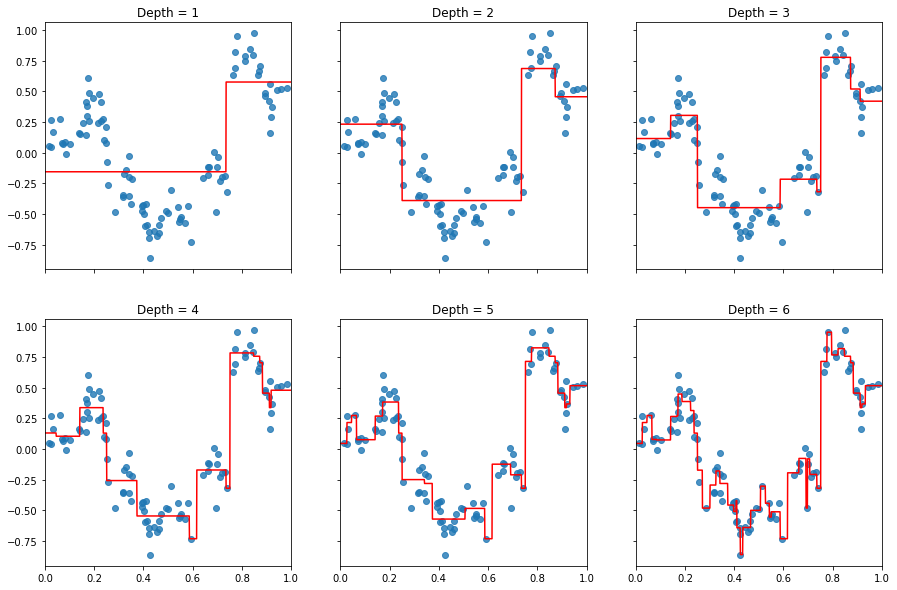

In [189]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Compare with scikit-learn for debugging

In [193]:
clf=DecisionTreeRegressor(criterion="mae", max_depth=6, min_samples_split=3)

In [194]:
clf.fit(x_krr_train, y_krr_train)

DecisionTreeRegressor(criterion='mae', max_depth=6, min_samples_split=3)

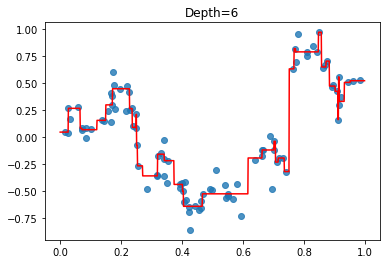

In [195]:
# Plotting decision regions
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)
y_range_predict = np.array([clf.predict(x.reshape(-1,1)) for x in x_range]).reshape(-1, 1)

plt.plot(x_range, y_range_predict, color='r')
plt.scatter(x_krr_train, y_krr_train, alpha=0.8)
plt.title("Depth="+str(clf.max_depth))
plt.show()

# Gradient Boosting Method

In [196]:
#Pseudo-residual function.
def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

### Question 5

In [197]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth

        self.estimators = [] #will collect the n_estimator models
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, n_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        #Initialize raw predictions and residuals
        raw_predictions = np.array([np.mean(train_target) for i in range(train_target.shape[0])])#average of target values
        residuals = self.pseudo_residual_func(train_target,raw_predictions)
        
        #Save the initial predictions of training data
        self.raw_prediction_train = np.mean(train_target)
        
        while len(self.estimators) <= self.n_estimator:   
            #Induce regression tree on residuals
            tree = DecisionTreeRegressor(
                    criterion="mse",
                    splitter="best",
                    max_depth=self.max_depth,
                    min_samples_split=self.min_sample
            )
            
            #Fit on residuals
            tree.fit(train_data, residuals)
        
            #Add tree to ensemble
            self.estimators.append(tree)
                
            #Update raw_predictions and residuals
            raw_predictions += self.learning_rate * tree.predict(train_data)
            residuals = self.pseudo_residual_func(train_target,raw_predictions)
        
        return self
    
    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, n_features)
        '''
        test_predict = np.array([self.raw_prediction_train for i in range(len(test_data))])
        for i in range(self.n_estimator):
            test_predict += self.learning_rate * (self.estimators[i]).predict(test_data)
            
        return test_predict


# 1-D GBM visualization - KRR data

### Question 6

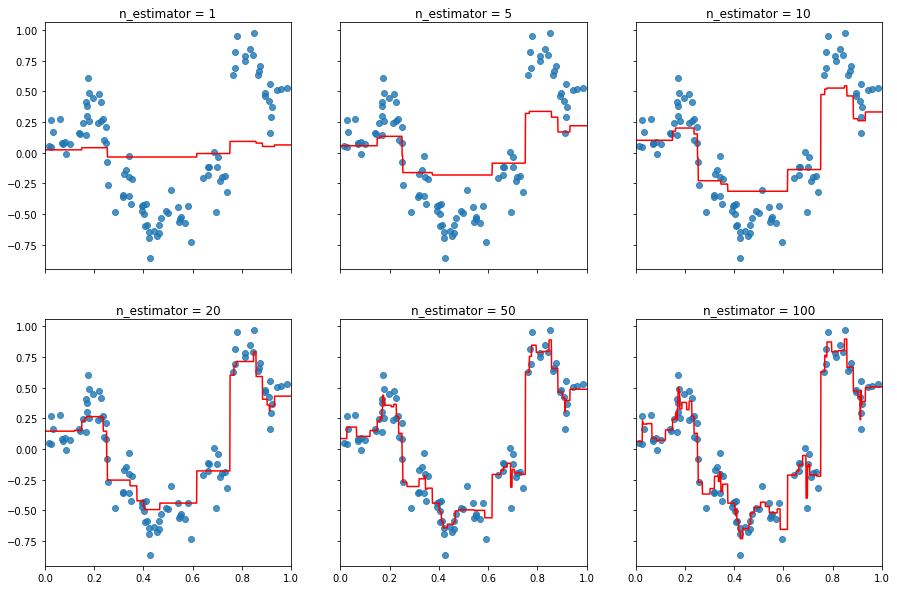

In [198]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

# Sklearn implementation for Classification of images

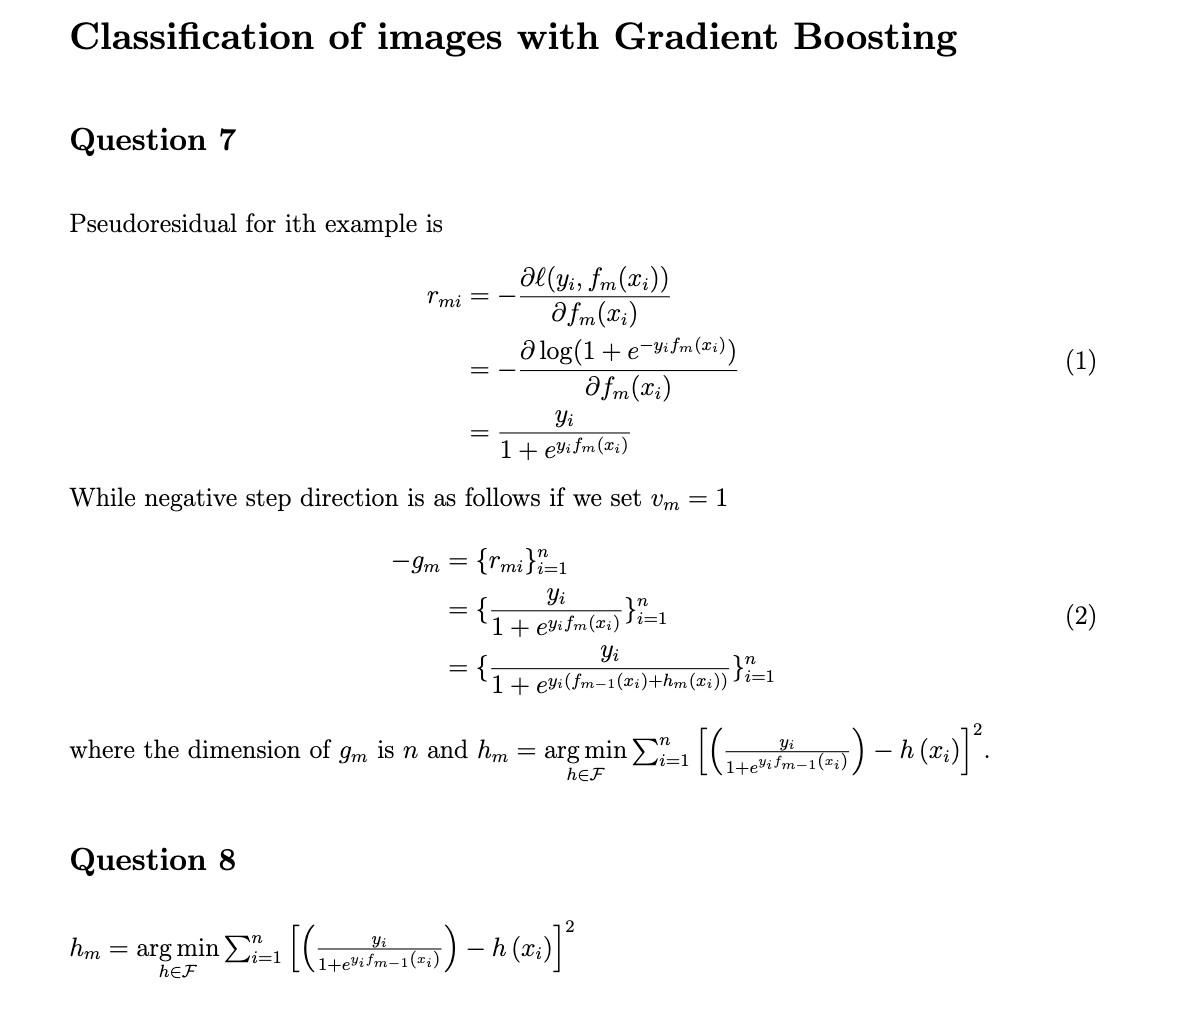

In [200]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state


In [201]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1') 
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [202]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

### Question 9

In [218]:
train_acc = []
test_acc = []
for i in (2,5,10,100,200):
    gbm_image = GradientBoostingClassifier(n_estimators=i, 
                                           max_depth=3, 
                                           learning_rate=0.1,
                                           loss="deviance")  
    gbm_image.fit(X_train, y_train)
    train_acc.append(gbm_image.score(X_train, y_train))
    test_acc.append(gbm_image.score(X_test, y_test))

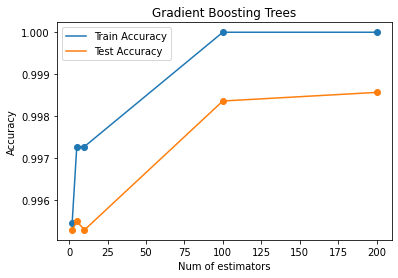

In [226]:
plt.plot((2,5,10,100,200), train_acc, label="Train Accuracy")
plt.scatter((2,5,10,100,200), train_acc)
plt.plot((2,5,10,100,200), test_acc, label="Test Accuracy")
plt.scatter((2,5,10,100,200), test_acc)
plt.xlabel("Num of estimators")
plt.ylabel("Accuracy")
plt.title("Gradient Boosting Trees")
plt.legend()
plt.show()

# Classification of images with Random Forests (Optional)

## Question 10

###  How Random Forest Works? 
Random Forest is a supervised learning algorithm. The "forest" it builds is an ensemble of decision trees, usually trained with the "bagging" method. The general idea of the bagging method is that a combination of learning models increase the overall result.
Put it simply, random forest builds multiple decision trees and merges them together to get a more accurate stable prediction.

### Steps involved in random forest algorithm

Random Forest ensures that the behavior of each individual tree is not too correlated with the behavior of any of the other trees in the model by using Bagging and Feature Randomness.

Step1: Take a random sample of size k(k<=N)with replacement from original dataset. If k equals to the size of original dataset(N), then we are doing bagging. In addition, we could also just use the whole dataset to build each tree.

Step2: Select m random features from all the features.(e.g., m=sqrt(n_features))

Step3: Individual decision trees are constructed for each sample.

Step4: Repeat the three steps above until n_estimators trees are built.

Step5: Each decision tree will generate an output.

Step6: Final output is considered based on Majority Voting or Averaging for classification and regression respectively.

### Question 11

In [220]:
rf_train_acc = []
rf_test_acc = []
for i in (2,5,10,100,200):
    rf_clf = RandomForestClassifier(n_estimators=i, 
                                    max_depth=3, 
                                    criterion="entropy")  
    rf_clf.fit(X_train, y_train)
    rf_train_acc.append(rf_clf.score(X_train, y_train))
    rf_test_acc.append(rf_clf.score(X_test, y_test))

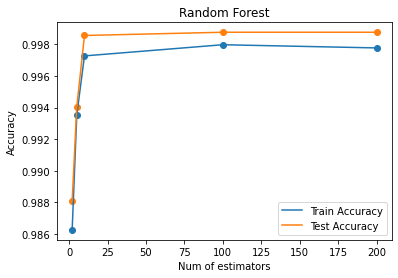

In [222]:
plt.plot((2,5,10,100,200), rf_train_acc, label="Train Accuracy")
plt.scatter((2,5,10,100,200), rf_train_acc)
plt.plot((2,5,10,100,200), rf_test_acc, label="Test Accuracy")
plt.scatter((2,5,10,100,200), rf_test_acc)
plt.xlabel("Num of estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Random Forest")
plt.show()

### Question 12
As we can see from the two figures above, the train_accuracy_GBT > train_accuracy_RF, while the test_accuracy_GBT is close to test_accuracy_RF. Thus GBT achieves the best train accuracy in general.

For GBT, the train_accuracy > test_accuracy, thus we could see it is overfitting. In fact, given that GBTs improve during training by learning on the residuals of previous steps, they could easily adapt too much by eliminating such residuals. And it is for this overfitting danger that GBTs should be used almost always with regularization during training, so that they do not use their full expressiveness on the training data.

However, for RF, we can see its train_accuracy < test_accuracy. As a result, random forests are much less likely to overfit than GBT in general because they are made up of many weak classifiers that are trained completely independently on different subsets of the training data. We can prevent overfitting in random forests by reducing tree path, reducing the number of samples at each split, or using more data.